**From the instructions**

Vision: Programming is more than writing code. The ultimate goal of the projects in this course
is that you learn to formulate a programming problem of your own choice, and find your own way
to solve it, and present the results. The bullets below are minimum requirements, but otherwise it is
very much up to you, what you will like to do with your project. I hope to see some creative ideas!

• Objectives: In your model analysis project, you should show that you can:
1. Apply model analysis methods (e.g. scipy.optimize, scipy.linalg, sympy)
2. Structure a code project
3. Document code
4. Present results in text form and in figures

• Content: In your model analysis project, you should at a minimum:
1. Describe an algorithm on how to solve a simple economic model (most likely taken from a textbook)
2. Solve (and perhaps simulate) a simple economic model
3. Visualize results across e.g. parametrizations
4. Analyze one or more extensions of the baseline model

• Structure: Your data analysis project should consist of:
1. A README.md with a short introduction to your project
2. A single self-contained notebook (.ipynb) presenting the analysis
3. (Optionally) Fully documented Python files (.py)
• Size: Quality before quantity.
• Hand-in: On GitHub by uploading it to the folder:
github.com/projects-2019-YOURGROUPNAME/modelproject/
• Deadline: 10th of May 23.59
• Supervision: The exercises class in the weeks starting 29th of April and 6th of May will
give you time to work on your model project and receive supervision from the lecturer and the
teaching assistants. Also, remember the online forum.
• Peer feedback: After handing in, you will be asked to give peer feedback on the projects of
two other groups.
• Exam: Your model analysis project will be a part of your exam portfolio. You are free to
incorporate the peer feedback and other comments before handing in the final version.

#### Overview of our project

**Overall subject**: Auction theory

Specifically, we want to numerically solve different of the standard auction models that we can solve analytically - e.g. first-price auctions with symmetric bidders with uniformly distributed valuations. We want to this, so we can check the numerical solution vs. analytical solution.

We might also try to investigate if we can solve some of the models, which become very cumbersome analytically - e.g. for non-uniform distribtions.

We could start off in the universe off (where we have analytical solutions) - e.g.:

1. 1st-price auctions with $N$ symmetric bidders with private valuations from $U[a,b]$
1. 2nd-price auctions with $N$ symmetric bidders with private valuations from $U[a,b]$
1. kth-price auctions with $N$ symmetric bidders with private valuations from $U[a,b]$

Ideally, we should be able to show:

1. Bidding strategies for individual bidders for given parameterizations and formats
1. Expected revenue for the auctioneer for given parameterizations and formats
1. Actual revenue (thus, also bids) for simulations

#### Imports

In [1]:
#Imports
import pandas as pd
import numpy as np
import random
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import functions

%load_ext autoreload
%autoreload 2

##### Draw relevant parameters

In [29]:
n = 10 # Number of bidders in the auction
a = 0 # Lowest possible valuation in the auction
b = 1 # highest possible valuation in the auction

all_valuations = np.random.uniform(a,b, n) # Draw all the bidders valuations from a uniform distribution
valuation = all_valuations[1] # Your valuation
max_valuation = max(all_valuations) # The highest valuations drawn in the auction
sellers_valuation = b # Sellers valuation of the good sold (this is set to the highest possible)

### 1st price auction (highest bid wins and pays the highest bid)

##### Optimal bidding strategy

Optimal to shade your bid. 
Bid your expectation of the second highest value conditional on winning


\begin{equation}
\beta^{I^*} = E(Y_1|Y_1 < x)
\end{equation}

In [30]:
optimal_bid = functions.opt_bid_k_price(k = 2, a = a, n = n, valuation = valuation) # you bid you expectation of the second highest bid contitional on winning
optimal_bid

0.307

##### Bidders Payoff

In [31]:
payoff = functions.bidders_payoff(optimal_bid = optimal_bid, 
                        highest_bid = functions.k_highest_bid(k = 1, all_valuations = all_valuations),
                        k_highest_bid = functions.k_highest_bid(k = 1, all_valuations = all_valuations))

payoff

0

Only if the bidders has the highest valuation and thereby places the highest bid he/she will win the auction and thereby get a positive payoff

##### Expected Revenue

The expected (ex ante) payoff from the auction depend on the number of bidders and the initial distribution of valuations by the bidders in the auction

In [32]:
expected_revenue = functions.expected_revenue_uniform(a = a, b = b, n = n)
expected_revenue

0.818

##### Actual Revenue

The actual revenue from the auction depend on the actual valuations drawn from the distribution.

In [33]:
actual_revenue = functions.actual_revenue_uniform(sellers_valuation = sellers_valuation, 
                                                  highest_bid = functions.k_highest_bid(k = 1, all_valuations = all_valuations))
actual_revenue

0.112

We see that the actual revenue is much lower than the expected revenue from this auction

### 2nd price auction (highest bid wins and pays the second highest bid)

##### Optimal bidding strategy

The optimal bidding strategy in a second price auction is to bid your valuation

\begin{equation}
\beta^{II^*} = x
\end{equation}

In [34]:
optimal_bid = functions.opt_bid_2_price(valuation = valuation)
optimal_bid

0.342

##### Bidders payoff

In [35]:
payoff = functions.bidders_payoff(optimal_bid = optimal_bid, 
                        highest_bid = functions.k_highest_bid(k = 1, all_valuations = all_valuations), 
                        k_highest_bid = functions.k_highest_bid(k = 2, all_valuations = all_valuations))
payoff

0

##### Expected Revenue of the seller

In [36]:
expected_revenue = functions.expected_revenue_uniform(a = a, b = b, n = n)
expected_revenue

0.818

##### Actual Revenue 

In [37]:
actual_revenue = functions.actual_revenue_uniform(sellers_valuation = sellers_valuation, 
                                                  highest_bid = functions.k_highest_bid(k = 1, all_valuations = all_valuations))
actual_revenue

0.112

### Extention:  kth-price auction (highest bid wins and pays the kth highest bid)

Optimal to shade your bid. 
Bid your expectation of the k highest value conditional on winning


\begin{equation}
\beta^{I^*} = E(Y_{k-1}|Y_{k-1} < x)
\end{equation}

##### Optimal bidding strategy

In [38]:
k = 5 # define auction format

In [39]:
optimal_bid = functions.opt_bid_k_price(k = k, a = a, n = n, valuation = valuation)
optimal_bid

0.205

##### Bidders Payoff

In [40]:
payoff = functions.bidders_payoff(optimal_bid = optimal_bid, 
                                  highest_bid = functions.k_highest_bid(k = 1, all_valuations = all_valuations), 
                                  k_highest_bid = functions.k_highest_bid(k = k, all_valuations = all_valuations))
payoff

0

##### Expected Revenue of the seller

In [41]:
expected_revenue = functions.expected_revenue_uniform(a = a, b = b, n = n)
expected_revenue

0.818

##### Actual revenue

In [42]:
actual_revenue =functions.actual_revenue_uniform(sellers_valuation = sellers_valuation, 
                                                   highest_bid = functions.k_highest_bid(k = 1, all_valuations = all_valuations))
actual_revenue

0.112

### Optimal bidding strategy plot

In [43]:
number_of_bidders = list(range(1,30)) # Create the first column with the number of bidders (x - axis)
df = pd.DataFrame(number_of_bidders)
df = df.rename(index=str, columns={0: "N bidders"})


# Adding one column to see how the optimal bidding stategy in a 1st price auction depend on the number of bidders
df['Optimal bid 1st price'] = functions.opt_bid_k_price(k = 2, a = a, n = df['N bidders'], valuation = valuation)

# Adding one column to see how the optimal bidding stategy in a 2nd price auction depend on the number of bidders
df['Optimal bid 2nd price'] = valuation
df['Optimal bid 2nd price'] = np.where(df['N bidders'] > 1, df['Optimal bid 2nd price'], np.nan) # Insert np.nan for bids with less than 2  bidders 
                                                                                                 #(you must have at least2 bidders in a 2nd price auction)

# Adding one column to see how the optimal bidding stategy in a 3rd price auction depend on the number of bidders
df['Optimal bid 3rd price'] = functions.opt_bid_k_price(k = 3, a = a, n = df['N bidders'], valuation = valuation)
df['Optimal bid 3rd price'] = np.where(df['N bidders'] > 2, df['Optimal bid 3rd price'], np.nan) # Insert np.nan for bids with less than 3 bidders 
                                                                                                 #(you must have at least3 bidders in a 3rd price auction)

# Adding one column to see how the optimal bidding stategy in a 5th price auction depend on the number of bidders
df['Optimal bid 5th price'] = functions.opt_bid_k_price(k = 5, a = a, n = df['N bidders'], valuation = valuation)
df['Optimal bid 5th price'] = np.where(df['N bidders'] > 4, df['Optimal bid 5th price'], np.nan) # Insert np.nan for bids with less than 5 bidders 
                                                                                                 #(you must have at least 5 bidders in a 5th price auction)
df.head()

,N bidders,Optimal bid 1st price,Optimal bid 2nd price,Optimal bid 3rd price,Optimal bid 5th price
0,1,0.000,NaN,NaN,NaN
1,2,0.171,0.341642,NaN,NaN
2,3,0.228,0.341642,0.114,NaN
3,4,0.256,0.341642,0.171,NaN
4,5,0.273,0.341642,0.205,0.068


Text(0.5, 1.0, 'Optimal bidding strategy by number of bidders')

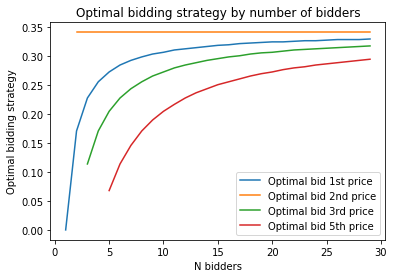

In [44]:
df.plot(x = 'N bidders') # Define what to plot (x - axis)
plt.ylabel('Optimal bidding strategy') # Label y axis
plt.title('Optimal bidding strategy by number of bidders') # add title to the plot

From the plot above, you can see how the optimal bidding strategy depend on the number of bidders for different auction formats. 
1. Second price auction: does not depend on number of bidders, but only on own valuation 
1. The other auction formats depend on the number of bidders. Th more bidders participating in the auction the less you shade your bid af the competition gets harder. 
1. The optimal bidding strategy depend on the auction format. The optimal bidding stategy is always higher in the 3rd price auction than i the 5th price auction. This is because the bidder optimizes the tradeoff of getting the highest payoff and risking not winning the auction.


### Expected revenue of the seller plot

Given the revenue equivalence theorem the expected reveue to the seller does not depend on the auction format. <br>
Given this we only need to look at one auction format to determine how expected revenue depend on the number of bidders 

In [45]:
number_of_bidders = list(range(1,30)) # Create the first column with the number of bidders (x - axis)
df = pd.DataFrame(number_of_bidders)
df = df.rename(index=str, columns={0: "N bidders"})


df['Expected revenue of the seller'] = functions.expected_revenue_uniform(a = a, b = b, n = df['N bidders']) # Include column with the expected revenue to the seller for different N values.
df.head()

,N bidders,Expected revenue of the seller
0,1,0.000
1,2,0.333
2,3,0.500
3,4,0.600
4,5,0.667


Text(0.5, 1.0, 'Expected revenue of the seller by number of bidders')

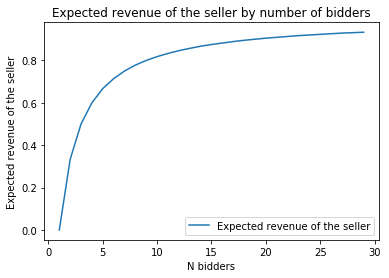

In [46]:
df.plot(x = 'N bidders') # Define what to plot (x - axis)
plt.ylabel('Expected revenue of the seller') # Label y axis
plt.title('Expected revenue of the seller by number of bidders') # add title to the plot

From the plot above, you can see how the expected revenue to the seller depend on the number of bidders. 
1. The expected revenue to the seller increase with the number of bidders. This is the case as: With more bidders in the auction the expected valuations are going to be higher.
